In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import math

C:\Users\igorr\AppData\Local\Temp\ipykernel_101872\1775820158.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


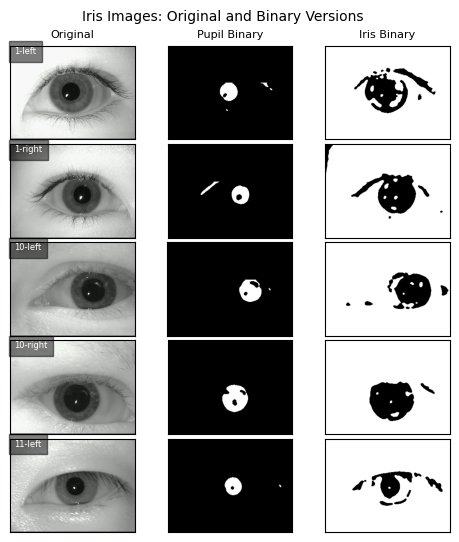

In [7]:
def preprocess(gray_img, blur_ksize=5):
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray_img)
    bilateral = cv2.bilateralFilter(enhanced, 9, 75, 75)
    blurred = cv2.GaussianBlur(bilateral, (blur_ksize, blur_ksize), 0)
    return blurred

def show_samples(base_path="data/MMU-Iris-Database", num_samples=5):
    samples = []
    for subject in sorted(os.listdir(base_path)):
        subject_path = os.path.join(base_path, subject)
        if not os.path.isdir(subject_path):
            continue

        for eye in ['left', 'right']:
            eye_path = os.path.join(subject_path, eye)
            if not os.path.isdir(eye_path):
                continue

            for img_file in sorted(os.listdir(eye_path)):
                if img_file.endswith('.bmp'):
                    img_path = os.path.join(eye_path, img_file)
                    samples.append((subject, eye, img_path))
                    break

        if len(samples) >= num_samples:
            break

    plt.rcParams.update({
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'savefig.facecolor': 'white'
    })

    fig, axes = plt.subplots(
        num_samples, 3,
        figsize=(6, 1.2 * num_samples),
        gridspec_kw={'wspace': 0.05, 'hspace': 0.05}
    )

    fig.patch.set_facecolor('white')
    fig.suptitle("Iris Images: Original and Binary Versions", fontsize=10, y=0.98)

    for i, (subject, eye, img_path) in enumerate(samples[:num_samples]):
        img = cv2.imread(img_path)
        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        processed = preprocess(gray)

        mean_value = np.mean(gray)
        pupil_threshold = mean_value / 3.5
        iris_threshold = mean_value / 1.8

        h, w = gray.shape
        y_start = int(h * 0.4)
        roi = processed[y_start:, :]

        _, pupil_binary_roi = cv2.threshold(roi, pupil_threshold, 255, cv2.THRESH_BINARY_INV)
        kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        pupil_binary_roi = cv2.morphologyEx(pupil_binary_roi, cv2.MORPH_OPEN, kernel_open)
        pupil_binary_roi = cv2.morphologyEx(pupil_binary_roi, cv2.MORPH_CLOSE, kernel_close)

        pupil_binary = np.zeros_like(gray)
        pupil_binary[y_start:, :] = pupil_binary_roi

        _, iris_binary = cv2.threshold(processed, iris_threshold, 255, cv2.THRESH_BINARY)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        iris_binary = cv2.morphologyEx(iris_binary, cv2.MORPH_OPEN, kernel)
        iris_binary = cv2.morphologyEx(iris_binary, cv2.MORPH_CLOSE, kernel)

        axes[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if i == 0:
            axes[i, 0].set_title("Original", fontsize=8)

        axes[i, 0].text(10, 20, f"{subject}-{eye}", fontsize=6,
                       color='white', bbox=dict(facecolor='black', alpha=0.5))
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])

        axes[i, 1].imshow(pupil_binary, cmap='gray')
        if i == 0:
            axes[i, 1].set_title("Pupil Binary", fontsize=8)
        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])

        axes[i, 2].imshow(iris_binary, cmap='gray')
        if i == 0:
            axes[i, 2].set_title("Iris Binary", fontsize=8)
        axes[i, 2].set_xticks([])
        axes[i, 2].set_yticks([])

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.05, top=0.92)

    plt.savefig('iris_samples.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

show_samples()

C:\Users\igorr\AppData\Local\Temp\ipykernel_101872\600411879.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


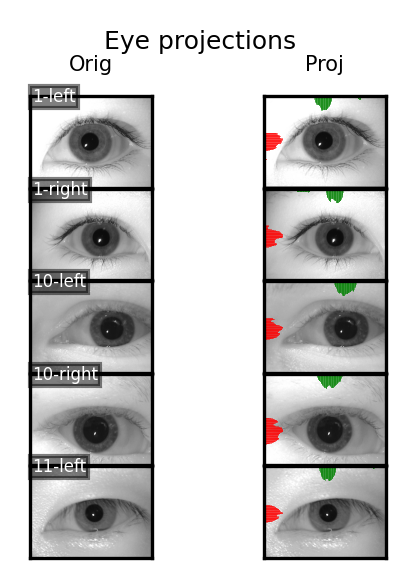

In [80]:
def calculate_projections(binary_image):
    horizontal_proj = np.sum(binary_image, axis=0)
    vertical_proj = np.sum(binary_image, axis=1)
    return horizontal_proj, vertical_proj

def create_eye_projections(base_path="data/MMU-Iris-Database", num_samples=5, output_file="eye_projections.png"):
    samples = []

    for subject in sorted(os.listdir(base_path)):
        subject_path = os.path.join(base_path, subject)
        if not os.path.isdir(subject_path):
            continue

        for eye in ['left', 'right']:
            eye_path = os.path.join(subject_path, eye)
            if not os.path.isdir(eye_path):
                continue

            for img_file in sorted(os.listdir(eye_path)):
                if img_file.endswith('.bmp'):
                    img_path = os.path.join(eye_path, img_file)
                    samples.append((subject, eye, img_path))
                    break

    if len(samples) == 0:
        print("No images found")
        return

    samples = samples[:num_samples]

    fig, axes = plt.subplots(
        nrows=len(samples),
        ncols=2,
        figsize=(2.0, 0.4*len(samples)),
        dpi=300,
        gridspec_kw={'hspace': 0.01, 'wspace': 0.01}
    )

    fig.patch.set_facecolor('white')

    for i, (subject, eye, img_path) in enumerate(samples):
        img = cv2.imread(img_path)
        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        processed = preprocess(gray)

        mean_value = np.mean(gray)
        pupil_threshold = mean_value / 3.5

        h, w = gray.shape
        y_start = int(h * 0.4)
        roi = processed[y_start:, :]

        _, pupil_binary_roi = cv2.threshold(roi, pupil_threshold, 255, cv2.THRESH_BINARY_INV)
        kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        pupil_binary_roi = cv2.morphologyEx(pupil_binary_roi, cv2.MORPH_OPEN, kernel_open)
        pupil_binary_roi = cv2.morphologyEx(pupil_binary_roi, cv2.MORPH_CLOSE, kernel_close)

        pupil_binary = np.zeros_like(gray)
        pupil_binary[y_start:, :] = pupil_binary_roi

        h_proj, v_proj = calculate_projections(pupil_binary)

        max_h_proj = max(np.max(h_proj), 1)
        max_v_proj = max(np.max(v_proj), 1)

        h_scale = 0.15
        v_scale = 0.15

        h_proj_scaled = h_proj / max_h_proj * h * h_scale
        v_proj_scaled = v_proj / max_v_proj * w * v_scale

        axes[i, 0].imshow(gray, cmap='gray')
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        axes[i, 0].text(5, 15, f"{subject}-{eye}", fontsize=4,
                       color='white', bbox=dict(facecolor='black', alpha=0.5, pad=0.5))

        axes[i, 1].imshow(gray, cmap='gray')

        for x in range(w):
            if h_proj[x] > 0:
                axes[i, 1].plot([x, x], [0, h_proj_scaled[x]], 'g-', linewidth=0.2, alpha=0.6)

        for y in range(h):
            if v_proj[y] > 0:
                axes[i, 1].plot([0, v_proj_scaled[y]], [y, y], 'r-', linewidth=0.2, alpha=0.6)

        axes[i, 1].set_xlim(0, w)
        axes[i, 1].set_ylim(h, 0)
        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])

    if len(samples) > 0:
        axes[0, 0].set_title('Orig', fontsize=5)
        axes[0, 1].set_title('Proj', fontsize=5)

    plt.suptitle("Eye projections", fontsize=6, y=0.99)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0.01, facecolor='white', dpi=400)
    plt.show()

create_eye_projections()

C:\Users\igorr\AppData\Local\Temp\ipykernel_101872\146273588.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


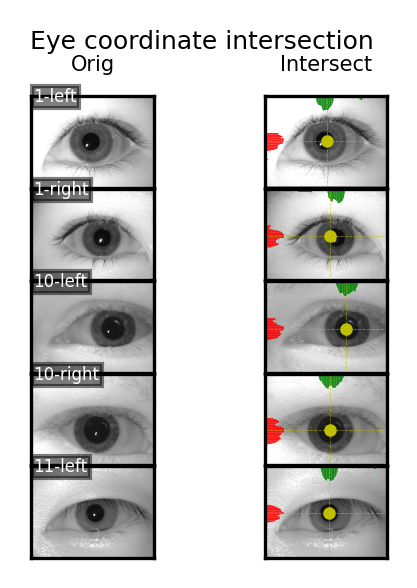

In [81]:
def find_center_by_projections(binary_image):
    horizontal_proj, vertical_proj = calculate_projections(binary_image)

    if np.max(horizontal_proj) == 0:
        cx = binary_image.shape[1] // 2
    else:
        x_indices = np.arange(len(horizontal_proj))
        non_zero_h = np.sum(horizontal_proj)
        if non_zero_h > 0:
            cx = int(np.sum(x_indices * horizontal_proj) / non_zero_h)
        else:
            cx = binary_image.shape[1] // 2

    if np.max(vertical_proj) == 0:
        cy = binary_image.shape[0] // 2
    else:
        y_indices = np.arange(len(vertical_proj))
        non_zero_v = np.sum(vertical_proj)
        if non_zero_v > 0:
            cy = int(np.sum(y_indices * vertical_proj) / non_zero_v)
        else:
            cy = binary_image.shape[0] // 2

    return cx, cy

def visualize_coordinate_intersection(base_path="data/MMU-Iris-Database", num_samples=5, output_file="eye_intersection.png"):
    samples = []

    for subject in sorted(os.listdir(base_path)):
        subject_path = os.path.join(base_path, subject)
        if not os.path.isdir(subject_path):
            continue

        for eye in ['left', 'right']:
            eye_path = os.path.join(subject_path, eye)
            if not os.path.isdir(eye_path):
                continue

            for img_file in sorted(os.listdir(eye_path)):
                if img_file.endswith('.bmp'):
                    img_path = os.path.join(eye_path, img_file)
                    samples.append((subject, eye, img_path))
                    break

    if len(samples) == 0:
        print("No images found")
        return

    samples = samples[:num_samples]

    fig, axes = plt.subplots(
        nrows=len(samples),
        ncols=2,
        figsize=(2.0, 0.4*len(samples)),
        dpi=300,
        gridspec_kw={'hspace': 0.01, 'wspace': 0.01}
    )

    fig.patch.set_facecolor('white')

    for i, (subject, eye, img_path) in enumerate(samples):
        img = cv2.imread(img_path)
        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        processed = preprocess(gray)

        mean_value = np.mean(gray)
        pupil_threshold = mean_value / 3.5

        h, w = gray.shape
        y_start = int(h * 0.4)
        roi = processed[y_start:, :]

        _, pupil_binary_roi = cv2.threshold(roi, pupil_threshold, 255, cv2.THRESH_BINARY_INV)
        kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        pupil_binary_roi = cv2.morphologyEx(pupil_binary_roi, cv2.MORPH_OPEN, kernel_open)
        pupil_binary_roi = cv2.morphologyEx(pupil_binary_roi, cv2.MORPH_CLOSE, kernel_close)

        pupil_binary = np.zeros_like(gray)
        pupil_binary[y_start:, :] = pupil_binary_roi

        center_x, center_y = find_center_by_projections(pupil_binary)

        h_proj, v_proj = calculate_projections(pupil_binary)

        max_h_proj = max(np.max(h_proj), 1)
        max_v_proj = max(np.max(v_proj), 1)

        h_scale = 0.15
        v_scale = 0.15

        h_proj_scaled = h_proj / max_h_proj * h * h_scale
        v_proj_scaled = v_proj / max_v_proj * w * v_scale

        axes[i, 0].imshow(gray, cmap='gray')
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        axes[i, 0].text(5, 15, f"{subject}-{eye}", fontsize=4,
                       color='white', bbox=dict(facecolor='black', alpha=0.5, pad=0.5))

        axes[i, 1].imshow(gray, cmap='gray')

        for x in range(w):
            if h_proj[x] > 0:
                axes[i, 1].plot([x, x], [0, h_proj_scaled[x]], 'g-', linewidth=0.2, alpha=0.6)

        for y in range(h):
            if v_proj[y] > 0:
                axes[i, 1].plot([0, v_proj_scaled[y]], [y, y], 'r-', linewidth=0.2, alpha=0.6)

        axes[i, 1].plot([center_x, center_x], [0, h], 'y--', linewidth=0.2, alpha=0.6)
        axes[i, 1].plot([0, w], [center_y, center_y], 'y--', linewidth=0.2, alpha=0.6)
        axes[i, 1].plot(center_x, center_y, 'yo', markersize=2)

        axes[i, 1].set_xlim(0, w)
        axes[i, 1].set_ylim(h, 0)
        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])

    if len(samples) > 0:
        axes[0, 0].set_title('Orig', fontsize=5)
        axes[0, 1].set_title('Intersect', fontsize=5)

    plt.suptitle("Eye coordinate intersection", fontsize=6, y=0.99)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0.01, facecolor='white', dpi=400)
    plt.show()

visualize_coordinate_intersection()

C:\Users\igorr\AppData\Local\Temp\ipykernel_101872\4009548588.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


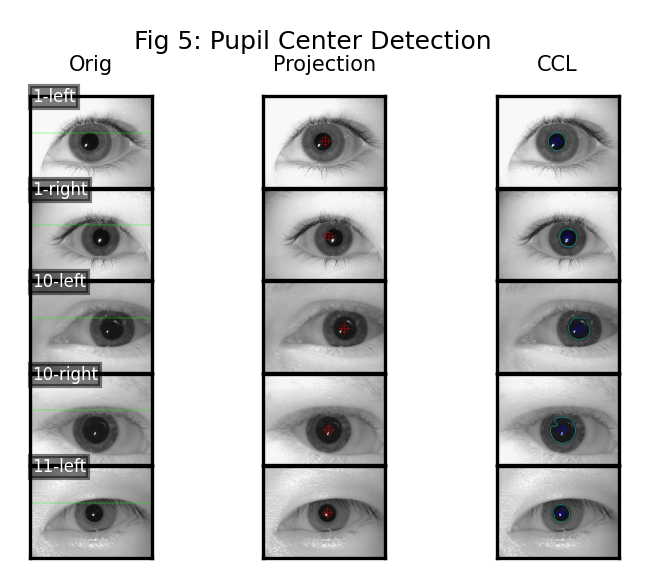

In [83]:
def visualize_pupil_center_detection(base_path="data/MMU-Iris-Database", num_samples=5, output_file="pupil_center_detection.png"):

    def find_center_by_projections(binary_image):
        horizontal_proj, vertical_proj = calculate_projections(binary_image)

        if np.max(horizontal_proj) == 0:
            cx = binary_image.shape[1] // 2
        else:
            x_indices = np.arange(len(horizontal_proj))
            non_zero_h = np.sum(horizontal_proj)
            if non_zero_h > 0:
                cx = int(np.sum(x_indices * horizontal_proj) / non_zero_h)
            else:
                cx = binary_image.shape[1] // 2

        if np.max(vertical_proj) == 0:
            cy = binary_image.shape[0] // 2
        else:
            y_indices = np.arange(len(vertical_proj))
            non_zero_v = np.sum(vertical_proj)
            if non_zero_v > 0:
                cy = int(np.sum(y_indices * vertical_proj) / non_zero_v)
            else:
                cy = binary_image.shape[0] // 2

        return cx, cy

    samples = []

    for subject in sorted(os.listdir(base_path)):
        subject_path = os.path.join(base_path, subject)
        if not os.path.isdir(subject_path):
            continue

        for eye in ['left', 'right']:
            eye_path = os.path.join(subject_path, eye)
            if not os.path.isdir(eye_path):
                continue

            for img_file in sorted(os.listdir(eye_path)):
                if img_file.endswith('.bmp'):
                    img_path = os.path.join(eye_path, img_file)
                    samples.append((subject, eye, img_path))
                    break

    if len(samples) == 0:
        print("No images found")
        return

    samples = samples[:num_samples]

    fig, axes = plt.subplots(
        nrows=len(samples),
        ncols=3,
        figsize=(3.0, 0.4*len(samples)),
        dpi=300,
        gridspec_kw={'hspace': 0.01, 'wspace': 0.01}
    )

    fig.patch.set_facecolor('white')

    for i, (subject, eye, img_path) in enumerate(samples):
        img = cv2.imread(img_path)
        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        processed = preprocess(gray)

        global_mean = np.mean(gray)
        pupil_threshold = global_mean / 3.5

        h, w = gray.shape
        y_start = int(h * 0.4)
        roi = processed[y_start:, :]
        roi_height = h - y_start

        _, pupil_binary_roi = cv2.threshold(roi, pupil_threshold, 255, cv2.THRESH_BINARY_INV)
        kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        pupil_binary_roi = cv2.morphologyEx(pupil_binary_roi, cv2.MORPH_OPEN, kernel_open)
        pupil_binary_roi = cv2.morphologyEx(pupil_binary_roi, cv2.MORPH_CLOSE, kernel_close)

        roi_center_x, roi_center_y = find_center_by_projections(pupil_binary_roi)
        center_x = roi_center_x
        center_y = roi_center_y + y_start

        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(pupil_binary_roi)
        min_dist = float('inf')
        best_label = 0

        for j in range(1, num_labels):
            component_center_x, component_center_y = centroids[j]
            dist = ((component_center_x - roi_center_x) ** 2 +
                    (component_center_y - roi_center_y) ** 2) ** 0.5

            area = stats[j, cv2.CC_STAT_AREA]
            weighted_dist = dist / (area ** 0.5)

            if weighted_dist < min_dist:
                min_dist = weighted_dist
                best_label = j

        clean_pupil_roi = np.zeros_like(pupil_binary_roi)
        if best_label > 0:
            clean_pupil_roi[labels == best_label] = 255
            refined_roi_center_x, refined_roi_center_y = find_center_by_projections(clean_pupil_roi)
            refined_center_x = refined_roi_center_x
            refined_center_y = refined_roi_center_y + y_start
        else:
            refined_center_x, refined_center_y = center_x, center_y

        vis_original = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        vis_projection = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        vis_ccl = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

        cv2.rectangle(vis_original, (0, y_start), (w, h), (0, 255, 0), 1)

        cv2.circle(vis_projection, (center_x, center_y), 10, (0, 0, 255), 1)
        cv2.line(vis_projection, (center_x - 15, center_y), (center_x + 15, center_y), (0, 0, 255), 1)
        cv2.line(vis_projection, (center_x, center_y - 15), (center_x, center_y + 15), (0, 0, 255), 1)

        cv2.circle(vis_ccl, (refined_center_x, refined_center_y), 10, (255, 0, 0), 1)
        cv2.line(vis_ccl, (refined_center_x - 15, refined_center_y), (refined_center_x + 15, refined_center_y), (255, 0, 0), 1)
        cv2.line(vis_ccl, (refined_center_x, refined_center_y - 15), (refined_center_x, refined_center_y + 15), (255, 0, 0), 1)

        if best_label > 0:
            contours, _ = cv2.findContours(clean_pupil_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                adjusted_contour = contour.copy()
                adjusted_contour[:,:,1] += y_start
                cv2.drawContours(vis_ccl, [adjusted_contour], -1, (255, 255, 0), 1)

        axes[i, 0].imshow(cv2.cvtColor(vis_original, cv2.COLOR_BGR2RGB))
        axes[i, 0].text(5, 15, f"{subject}-{eye}", fontsize=4,
                       color='white', bbox=dict(facecolor='black', alpha=0.5, pad=0.5))
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])

        axes[i, 1].imshow(cv2.cvtColor(vis_projection, cv2.COLOR_BGR2RGB))
        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])

        axes[i, 2].imshow(cv2.cvtColor(vis_ccl, cv2.COLOR_BGR2RGB))
        axes[i, 2].set_xticks([])
        axes[i, 2].set_yticks([])

    if len(samples) > 0:
        axes[0, 0].set_title('Orig', fontsize=5)
        axes[0, 1].set_title('Projection', fontsize=5)
        axes[0, 2].set_title('CCL', fontsize=5)

    plt.suptitle("Fig 5: Pupil Center Detection", fontsize=6, y=0.99)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0.01, facecolor='white', dpi=400)
    plt.show()

visualize_pupil_center_detection()

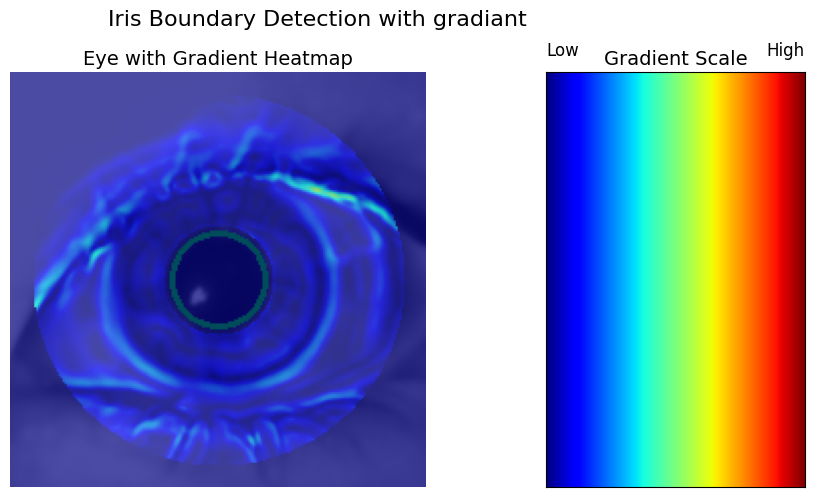

In [85]:
def visualize_gradient_heatmap(image_path="data/MMU-Iris-Database/1/left/aeval5.bmp", output_file="iris_gradient_heatmap.png"):

    def estimate_radius_by_projections(binary_image, center):
        cx, cy = center
        h, w = binary_image.shape

        horizontal_profile = binary_image[cy, :] if 0 <= cy < h else np.zeros(w)
        vertical_profile = binary_image[:, cx] if 0 <= cx < w else np.zeros(h)

        left_radius = 0
        for i in range(cx, 0, -1):
            if horizontal_profile[i] == 0: break
            left_radius += 1

        right_radius = 0
        for i in range(cx, w - 1):
            if horizontal_profile[i] == 0: break
            right_radius += 1

        top_radius = 0
        for i in range(cy, 0, -1):
            if vertical_profile[i] == 0: break
            top_radius += 1

        bottom_radius = 0
        for i in range(cy, h - 1):
            if vertical_profile[i] == 0: break
            bottom_radius += 1

        radius = int((left_radius + right_radius + top_radius + bottom_radius) / 4)
        return max(radius, 5)

    def detect_pupil_boundary(gray_img, processed_img, threshold):
        h, w = gray_img.shape
        y_start = int(h * 0.4)
        roi = processed_img[y_start:, :]

        _, pupil_binary_roi = cv2.threshold(roi, threshold, 255, cv2.THRESH_BINARY_INV)

        kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        pupil_binary_roi = cv2.morphologyEx(pupil_binary_roi, cv2.MORPH_OPEN, kernel_open)
        pupil_binary_roi = cv2.morphologyEx(pupil_binary_roi, cv2.MORPH_CLOSE, kernel_close)

        pupil_binary = np.zeros_like(gray_img)
        pupil_binary[y_start:, :] = pupil_binary_roi

        if np.count_nonzero(pupil_binary_roi) == 0:
            return None, pupil_binary

        roi_center_x, roi_center_y = find_center_by_projections(pupil_binary_roi)
        center_x = roi_center_x
        center_y = roi_center_y + y_start

        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(pupil_binary_roi)
        min_dist = float('inf')
        best_label = 0

        for i in range(1, num_labels):
            component_center_x, component_center_y = centroids[i]
            dist = ((component_center_x - roi_center_x) ** 2 +
                    (component_center_y - roi_center_y) ** 2) ** 0.5

            area = stats[i, cv2.CC_STAT_AREA]
            weighted_dist = dist / (area ** 0.5)

            if weighted_dist < min_dist:
                min_dist = weighted_dist
                best_label = i

        if best_label > 0:
            clean_pupil_roi = np.zeros_like(pupil_binary_roi)
            clean_pupil_roi[labels == best_label] = 255
            pupil_binary[y_start:, :] = clean_pupil_roi

            roi_center_x, roi_center_y = find_center_by_projections(clean_pupil_roi)
            center_x = roi_center_x
            center_y = roi_center_y + y_start

            radius = estimate_radius_by_projections(clean_pupil_roi, (roi_center_x, roi_center_y))
            return (center_x, center_y, radius), pupil_binary
        else:
            return None, pupil_binary

    original_bgr = cv2.imread(image_path)
    if original_bgr is None:
        raise FileNotFoundError(f"Cannot read image: {image_path}")

    gray = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2GRAY)
    gray_processed = preprocess(gray)

    global_mean = np.sum(gray) / (gray.shape[0] * gray.shape[1])
    pupil_threshold = global_mean / 3.5

    pupil_boundary, _ = detect_pupil_boundary(gray, gray_processed, pupil_threshold)

    if pupil_boundary is None:
        print("Failed to detect pupil boundary")
        return

    pupil_x, pupil_y, pupil_radius = pupil_boundary

    roi_radius = int(pupil_radius * 4.5)
    roi_x1 = max(0, pupil_x - roi_radius)
    roi_y1 = max(0, pupil_y - roi_radius)
    roi_x2 = min(gray.shape[1], pupil_x + roi_radius)
    roi_y2 = min(gray.shape[0], pupil_y + roi_radius)

    pupil_roi_x = pupil_x - roi_x1
    pupil_roi_y = pupil_y - roi_y1

    roi_gray = gray_processed[roi_y1:roi_y2, roi_x1:roi_x2].copy()

    gx = cv2.Sobel(roi_gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(roi_gray, cv2.CV_32F, 0, 1, ksize=3)
    edge_map = cv2.magnitude(gx, gy)
    edge_map_blurred = cv2.GaussianBlur(edge_map, (3, 3), 0)

    edge_map_norm = cv2.normalize(edge_map_blurred, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    mask = np.zeros_like(roi_gray)
    cv2.circle(mask, (pupil_roi_x, pupil_roi_y), int(pupil_radius * 4), 255, -1)
    cv2.circle(mask, (pupil_roi_x, pupil_roi_y), int(pupil_radius * 1.2), 0, -1)

    masked_edge_map = cv2.bitwise_and(edge_map_norm, edge_map_norm, mask=mask)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [3, 1]})

    overlay = cv2.cvtColor(roi_gray, cv2.COLOR_GRAY2BGR)

    cv2.circle(overlay, (pupil_roi_x, pupil_roi_y), pupil_radius, (0, 255, 0), 2)

    heatmap = cv2.applyColorMap(masked_edge_map, cv2.COLORMAP_JET)

    alpha = 0.7
    overlay_with_heatmap = cv2.addWeighted(overlay, 1-alpha, heatmap, alpha, 0)

    ax1.imshow(cv2.cvtColor(overlay_with_heatmap, cv2.COLOR_BGR2RGB))
    ax1.set_title("Eye with Gradient Heatmap", fontsize=14)
    ax1.axis('off')

    gradient_range = np.linspace(0, 255, 256)
    gradient = np.vstack([gradient_range] * 20)
    ax2.imshow(gradient, aspect='auto', cmap='jet')
    ax2.set_title("Gradient Scale", fontsize=14)

    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.text(0, -2, "Low", ha='left', va='top', fontsize=12)
    ax2.text(255, -2, "High", ha='right', va='top', fontsize=12)

    plt.suptitle("Iris Boundary Detection with gradiant", fontsize=16)
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()

visualize_gradient_heatmap()

C:\Users\igorr\AppData\Local\Temp\ipykernel_101872\4241424778.py:305: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


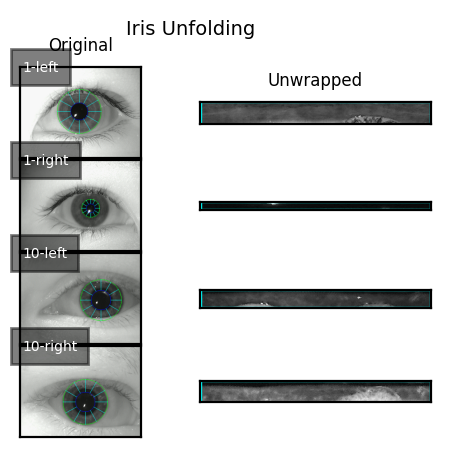

In [86]:
def estimate_radius_by_projections(binary_image, center):
    cx, cy = center
    h, w = binary_image.shape

    horizontal_profile = binary_image[cy, :] if 0 <= cy < h else np.zeros(w)
    vertical_profile = binary_image[:, cx] if 0 <= cx < w else np.zeros(h)

    left_radius = 0
    for i in range(cx, 0, -1):
        if horizontal_profile[i] == 0: break
        left_radius += 1

    right_radius = 0
    for i in range(cx, w - 1):
        if horizontal_profile[i] == 0: break
        right_radius += 1

    top_radius = 0
    for i in range(cy, 0, -1):
        if vertical_profile[i] == 0: break
        top_radius += 1

    bottom_radius = 0
    for i in range(cy, h - 1):
        if vertical_profile[i] == 0: break
        bottom_radius += 1

    radius = int((left_radius + right_radius + top_radius + bottom_radius) / 4)
    return max(radius, 5)

def detect_pupil_boundary(gray_img, processed_img, threshold):
    h, w = gray_img.shape
    y_start = int(h * 0.4)
    roi = processed_img[y_start:, :]

    _, pupil_binary_roi = cv2.threshold(roi, threshold, 255, cv2.THRESH_BINARY_INV)

    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    pupil_binary_roi = cv2.morphologyEx(pupil_binary_roi, cv2.MORPH_OPEN, kernel_open)
    pupil_binary_roi = cv2.morphologyEx(pupil_binary_roi, cv2.MORPH_CLOSE, kernel_close)

    pupil_binary = np.zeros_like(gray_img)
    pupil_binary[y_start:, :] = pupil_binary_roi

    if np.count_nonzero(pupil_binary_roi) == 0:
        return None, pupil_binary

    roi_center_x, roi_center_y = find_center_by_projections(pupil_binary_roi)
    center_x = roi_center_x
    center_y = roi_center_y + y_start

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(pupil_binary_roi)
    min_dist = float('inf')
    best_label = 0

    for i in range(1, num_labels):
        component_center_x, component_center_y = centroids[i]
        dist = ((component_center_x - roi_center_x) ** 2 +
                (component_center_y - roi_center_y) ** 2) ** 0.5

        area = stats[i, cv2.CC_STAT_AREA]
        weighted_dist = dist / (area ** 0.5)

        if weighted_dist < min_dist:
            min_dist = weighted_dist
            best_label = i

    if best_label > 0:
        clean_pupil_roi = np.zeros_like(pupil_binary_roi)
        clean_pupil_roi[labels == best_label] = 255
        pupil_binary[y_start:, :] = clean_pupil_roi

        roi_center_x, roi_center_y = find_center_by_projections(clean_pupil_roi)
        center_x = roi_center_x
        center_y = roi_center_y + y_start

        radius = estimate_radius_by_projections(clean_pupil_roi, (roi_center_x, roi_center_y))
        return (center_x, center_y, radius), pupil_binary
    else:
        return None, pupil_binary

def detect_iris_boundary(gray_img, processed_img, pupil_boundary, threshold):
    if pupil_boundary is None:
        return None

    pupil_x, pupil_y, pupil_radius = pupil_boundary

    roi_radius = int(pupil_radius * 4.5)
    roi_x1 = max(0, pupil_x - roi_radius)
    roi_y1 = max(0, pupil_y - roi_radius)
    roi_x2 = min(gray_img.shape[1], pupil_x + roi_radius)
    roi_y2 = min(gray_img.shape[0], pupil_y + roi_radius)

    pupil_roi_x = pupil_x - roi_x1
    pupil_roi_y = pupil_y - roi_y1

    roi_gray = processed_img[roi_y1:roi_y2, roi_x1:roi_x2].copy()

    gx = cv2.Sobel(roi_gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(roi_gray, cv2.CV_32F, 0, 1, ksize=3)
    edge_map = cv2.magnitude(gx, gy)
    edge_map = cv2.GaussianBlur(edge_map, (3, 3), 0)
    edge_map = cv2.normalize(edge_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    mask = np.zeros_like(roi_gray)
    cv2.circle(mask, (pupil_roi_x, pupil_roi_y), int(pupil_radius * 4), 255, -1)
    cv2.circle(mask, (pupil_roi_x, pupil_roi_y), int(pupil_radius * 1.2), 0, -1)
    edge_map = cv2.bitwise_and(edge_map, edge_map, mask=mask)

    angles = np.arange(0, 360, 5)
    radii = []
    min_r = int(pupil_radius * 1.5)
    max_r = int(pupil_radius * 4.0)

    for angle in angles:
        angle_rad = np.deg2rad(angle)
        cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
        radial_profile = []

        for r in range(min_r, max_r):
            x = int(pupil_roi_x + r * cos_a)
            y = int(pupil_roi_y + r * sin_a)

            if 0 <= x < edge_map.shape[1] and 0 <= y < edge_map.shape[0]:
                radial_profile.append((r, edge_map[y, x]))

        if radial_profile:
            best_r, _ = max(radial_profile, key=lambda p: p[1])
            radii.append(best_r)

    if radii:
        radii = np.array(radii)
        median_r = np.median(radii)
        mad = np.median(np.abs(radii - median_r))

        good_radii = radii[np.abs(radii - median_r) < 2.0 * mad]

        if len(good_radii) > 0:
            iris_radius = int(np.median(good_radii))
        else:
            iris_radius = int(median_r)
    else:
        h_proj = np.sum(edge_map, axis=0)
        v_proj = np.sum(edge_map, axis=1)

        h_indices = np.arange(len(h_proj))
        h_center = np.sum(h_indices * h_proj) / (np.sum(h_proj) + 1e-6)
        h_width = np.sqrt(np.sum((h_indices - h_center) ** 2 * h_proj) / (np.sum(h_proj) + 1e-6))

        v_indices = np.arange(len(v_proj))
        v_center = np.sum(v_indices * v_proj) / (np.sum(v_proj) + 1e-6)
        v_width = np.sqrt(np.sum((v_indices - v_center) ** 2 * v_proj) / (np.sum(v_proj) + 1e-6))

        iris_radius = int((h_width + v_width) / 2)

    iris_radius = max(int(pupil_radius * 2.0), min(iris_radius, int(pupil_radius * 4.0)))
    return (pupil_x, pupil_y, iris_radius)

def unwrap_iris(gray_img, pupil_boundary, iris_boundary):
    if pupil_boundary is None or iris_boundary is None:
        return np.zeros((100, 360), dtype=np.uint8)

    px, py, pr = pupil_boundary
    ix, iy, ir = iris_boundary

    center_x, center_y = px, py
    height = ir - pr
    width = 360

    unwrapped = np.zeros((height, width), dtype=np.uint8)

    for theta in range(width):
        angle_rad = np.deg2rad(theta)
        cos_t = np.cos(angle_rad)
        sin_t = np.sin(angle_rad)

        for r in range(height):
            radius = pr + r
            x = int(center_x + radius * cos_t)
            y = int(center_y + radius * sin_t)

            if 0 <= x < gray_img.shape[1] and 0 <= y < gray_img.shape[0]:
                unwrapped[r, theta] = gray_img[y, x]

    return unwrapped

def draw_unwrapping_lines(img, pupil_boundary, iris_boundary, num_lines=12):
    if pupil_boundary is None or iris_boundary is None:
        return img.copy()

    px, py, pr = pupil_boundary
    ix, iy, ir = iris_boundary

    result = img.copy()

    angles = np.linspace(0, 2*np.pi, num_lines, endpoint=False)

    for angle in angles:
        cos_t = np.cos(angle)
        sin_t = np.sin(angle)

        x1 = int(px + pr * cos_t)
        y1 = int(py + pr * sin_t)

        x2 = int(px + ir * cos_t)
        y2 = int(py + ir * sin_t)

        cv2.line(result, (x1, y1), (x2, y2), (0, 255, 255), 1)

    return result

def visualize_iris_unfolding(base_path="data/MMU-Iris-Database", num_samples=4, output_file="iris_unfolding.png"):
    samples = []

    for subject in sorted(os.listdir(base_path)):
        subject_path = os.path.join(base_path, subject)
        if not os.path.isdir(subject_path):
            continue

        for eye in ['left', 'right']:
            eye_path = os.path.join(subject_path, eye)
            if not os.path.isdir(eye_path):
                continue

            for img_file in sorted(os.listdir(eye_path)):
                if img_file.endswith('.bmp'):
                    img_path = os.path.join(eye_path, img_file)
                    samples.append((subject, eye, img_path))
                    break

            if len(samples) >= num_samples:
                break

        if len(samples) >= num_samples:
            break

    if len(samples) == 0:
        print("No images found")
        return

    fig, axes = plt.subplots(
        nrows=len(samples),
        ncols=2,
        figsize=(3.0, 0.6*len(samples)),
        dpi=200,
        gridspec_kw={'hspace': 0.02, 'wspace': 0.02}
    )

    fig.patch.set_facecolor('white')

    for i, (subject, eye, img_path) in enumerate(samples):
        img = cv2.imread(img_path)
        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        processed = preprocess(gray)

        global_mean = np.mean(gray)
        pupil_threshold = global_mean / 3.5
        iris_threshold = global_mean / 1.8

        pupil_boundary, _ = detect_pupil_boundary(gray, processed, pupil_threshold)

        if pupil_boundary is not None:
            iris_boundary = detect_iris_boundary(gray, processed, pupil_boundary, iris_threshold)
        else:
            iris_boundary = None

        result_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()

        if pupil_boundary and iris_boundary:
            px, py, pr = pupil_boundary
            ix, iy, ir = iris_boundary
            cv2.circle(result_img, (px, py), pr, (0, 0, 255), 1)
            cv2.circle(result_img, (ix, iy), ir, (0, 255, 0), 1)
            result_img = draw_unwrapping_lines(result_img, pupil_boundary, iris_boundary)

        axes[i, 0].imshow(result_img)
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        axes[i, 0].text(5, 10, f"{subject}-{eye}", fontsize=5,
                       color='white', bbox=dict(facecolor='black', alpha=0.5))

        if pupil_boundary and iris_boundary:
            unwrapped = unwrap_iris(gray, pupil_boundary, iris_boundary)
            axes[i, 1].imshow(unwrapped, cmap='gray')
            axes[i, 1].axhline(y=0, color='cyan', linestyle='-', linewidth=0.5)
            axes[i, 1].axhline(y=unwrapped.shape[0]-1, color='cyan', linestyle='-', linewidth=0.5)
            axes[i, 1].axvline(x=0, color='cyan', linestyle='-', linewidth=0.5)
            axes[i, 1].axvline(x=unwrapped.shape[1]-1, color='cyan', linestyle='-', linewidth=0.5)
        else:
            axes[i, 1].text(0.5, 0.5, "Failed", ha='center', va='center', fontsize=5)
            axes[i, 1].imshow(np.zeros((10, 10)), cmap='gray')

        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])

    if len(samples) > 0:
        axes[0, 0].set_title('Original', fontsize=6)
        axes[0, 1].set_title('Unwrapped', fontsize=6)

    plt.suptitle("Iris Unfolding", fontsize=7, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0.02, facecolor='white')
    plt.show()

visualize_iris_unfolding()

C:\Users\igorr\AppData\Local\Temp\ipykernel_101872\634119546.py:424: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


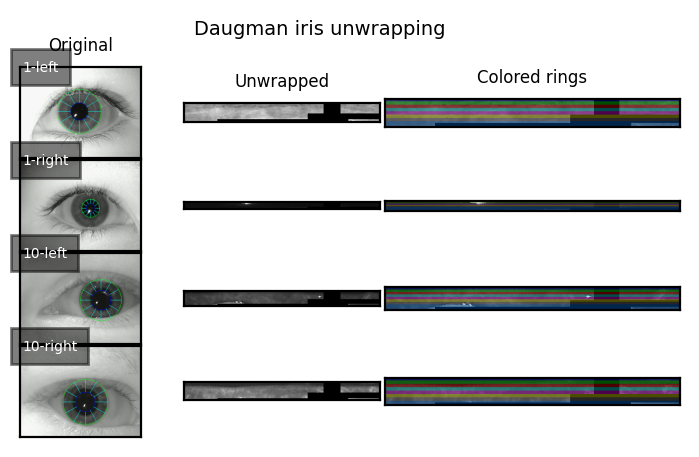

In [87]:
def detect_pupil_boundary(gray_img, processed_img, threshold):
    h, w = gray_img.shape
    y_start = int(h * 0.4)
    roi = processed_img[y_start:, :]

    _, pupil_binary_roi = cv2.threshold(roi, threshold, 255, cv2.THRESH_BINARY_INV)

    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    pupil_binary_roi = cv2.morphologyEx(pupil_binary_roi, cv2.MORPH_OPEN, kernel_open)
    pupil_binary_roi = cv2.morphologyEx(pupil_binary_roi, cv2.MORPH_CLOSE, kernel_close)

    pupil_binary = np.zeros_like(gray_img)
    pupil_binary[y_start:, :] = pupil_binary_roi

    if np.count_nonzero(pupil_binary_roi) == 0:
        return None, pupil_binary

    roi_center_x, roi_center_y = find_center_by_projections(pupil_binary_roi)
    center_x = roi_center_x
    center_y = roi_center_y + y_start

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(pupil_binary_roi)
    min_dist = float('inf')
    best_label = 0

    for i in range(1, num_labels):
        component_center_x, component_center_y = centroids[i]
        dist = ((component_center_x - roi_center_x) ** 2 +
                (component_center_y - roi_center_y) ** 2) ** 0.5

        area = stats[i, cv2.CC_STAT_AREA]
        weighted_dist = dist / (area ** 0.5)

        if weighted_dist < min_dist:
            min_dist = weighted_dist
            best_label = i

    if best_label > 0:
        clean_pupil_roi = np.zeros_like(pupil_binary_roi)
        clean_pupil_roi[labels == best_label] = 255
        pupil_binary[y_start:, :] = clean_pupil_roi

        roi_center_x, roi_center_y = find_center_by_projections(clean_pupil_roi)
        center_x = roi_center_x
        center_y = roi_center_y + y_start

        radius = estimate_radius_by_projections(clean_pupil_roi, (roi_center_x, roi_center_y))
        return (center_x, center_y, radius), pupil_binary
    else:
        return None, pupil_binary

def detect_iris_boundary(gray_img, processed_img, pupil_boundary, threshold):
    if pupil_boundary is None:
        return None

    pupil_x, pupil_y, pupil_radius = pupil_boundary

    roi_radius = int(pupil_radius * 4.5)
    roi_x1 = max(0, pupil_x - roi_radius)
    roi_y1 = max(0, pupil_y - roi_radius)
    roi_x2 = min(gray_img.shape[1], pupil_x + roi_radius)
    roi_y2 = min(gray_img.shape[0], pupil_y + roi_radius)

    pupil_roi_x = pupil_x - roi_x1
    pupil_roi_y = pupil_y - roi_y1

    roi_gray = processed_img[roi_y1:roi_y2, roi_x1:roi_x2].copy()

    gx = cv2.Sobel(roi_gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(roi_gray, cv2.CV_32F, 0, 1, ksize=3)
    edge_map = cv2.magnitude(gx, gy)
    edge_map = cv2.GaussianBlur(edge_map, (3, 3), 0)
    edge_map = cv2.normalize(edge_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    mask = np.zeros_like(roi_gray)
    cv2.circle(mask, (pupil_roi_x, pupil_roi_y), int(pupil_radius * 4), 255, -1)
    cv2.circle(mask, (pupil_roi_x, pupil_roi_y), int(pupil_radius * 1.2), 0, -1)
    edge_map = cv2.bitwise_and(edge_map, edge_map, mask=mask)

    angles = np.arange(0, 360, 5)
    radii = []
    min_r = int(pupil_radius * 1.5)
    max_r = int(pupil_radius * 4.0)

    for angle in angles:
        angle_rad = np.deg2rad(angle)
        cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
        radial_profile = []

        for r in range(min_r, max_r):
            x = int(pupil_roi_x + r * cos_a)
            y = int(pupil_roi_y + r * sin_a)

            if 0 <= x < edge_map.shape[1] and 0 <= y < edge_map.shape[0]:
                radial_profile.append((r, edge_map[y, x]))

        if radial_profile:
            best_r, _ = max(radial_profile, key=lambda p: p[1])
            radii.append(best_r)

    if radii:
        radii = np.array(radii)
        median_r = np.median(radii)
        mad = np.median(np.abs(radii - median_r))

        good_radii = radii[np.abs(radii - median_r) < 2.0 * mad]

        if len(good_radii) > 0:
            iris_radius = int(np.median(good_radii))
        else:
            iris_radius = int(median_r)
    else:
        h_proj = np.sum(edge_map, axis=0)
        v_proj = np.sum(edge_map, axis=1)

        h_indices = np.arange(len(h_proj))
        h_center = np.sum(h_indices * h_proj) / (np.sum(h_proj) + 1e-6)
        h_width = np.sqrt(np.sum((h_indices - h_center) ** 2 * h_proj) / (np.sum(h_proj) + 1e-6))

        v_indices = np.arange(len(v_proj))
        v_center = np.sum(v_indices * v_proj) / (np.sum(v_proj) + 1e-6)
        v_width = np.sqrt(np.sum((v_indices - v_center) ** 2 * v_proj) / (np.sum(v_proj) + 1e-6))

        iris_radius = int((h_width + v_width) / 2)

    iris_radius = max(int(pupil_radius * 2.0), min(iris_radius, int(pupil_radius * 4.0)))
    return (pupil_x, pupil_y, iris_radius)

def unwrap_iris_daugman(gray_img, pupil_boundary, iris_boundary):
    if pupil_boundary is None or iris_boundary is None:
        z = np.zeros((100, 360), np.uint8)
        return z, z

    cx, cy, _ = pupil_boundary
    _, _, pr = pupil_boundary
    _, _, ir = iris_boundary

    H = ir - pr
    if H <= 0:
        z = np.zeros((100, 360), np.uint8)
        return z, z

    W = 360
    ring_w = max(1, math.ceil(H / 8))
    img_h, img_w = gray_img.shape

    ang = [
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 225)],
        [(0, 225)],
        [(0, 60), (300, 359)],
        [(60, 149), (320, 359)],
    ]

    unwrapped = np.zeros((H, W), np.uint8)
    mask = np.zeros_like(unwrapped)

    cos_tbl = np.cos(np.deg2rad(np.arange(W)))
    sin_tbl = np.sin(np.deg2rad(np.arange(W)))

    for deg in range(W):
        for r in range(H):
            ring = min(7, r // ring_w)
            if not any(lo <= deg <= hi for lo, hi in ang[ring]):
                continue

            rr = pr + r
            x = int(cx + rr * cos_tbl[deg])
            y = int(cy + rr * sin_tbl[deg])
            if 0 <= x < img_w and 0 <= y < img_h:
                unwrapped[r, deg] = gray_img[y, x]
                mask[r, deg] = 255

    lashes = np.zeros_like(mask)
    for deg in range(W):
        col = unwrapped[:, deg][mask[:, deg] > 0]
        if col.size == 0:
            continue
        thr = np.percentile(col, 20)
        dark = unwrapped[:, deg] < thr
        lashes[:, deg][dark] = 255

    valid_pix = unwrapped[mask > 0]
    if valid_pix.size:
        mu, sigma = valid_pix.mean(), valid_pix.std()
        glare = (unwrapped > mu + 2.5 * sigma) & (mask > 0)
        lashes[glare] = 255

    h_k = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 3))
    lashes = cv2.morphologyEx(lashes, cv2.MORPH_DILATE, h_k, iterations=2)
    lashes = cv2.morphologyEx(lashes, cv2.MORPH_CLOSE, h_k, iterations=1)

    mask[lashes > 0] = 0

    return unwrapped, mask

def create_daugman_rings_visualization(daugman_unwrapped, pupil_boundary, iris_boundary):
    if (pupil_boundary is None or iris_boundary is None or daugman_unwrapped is None):
        return np.zeros((100, 360, 3), dtype=np.uint8)

    H, W = daugman_unwrapped.shape
    vis = cv2.cvtColor(daugman_unwrapped, cv2.COLOR_GRAY2BGR)
    ring_h = max(1, H // 8)

    ring_colours = [
        (255, 0, 0),
        (0, 255, 0),
        (0, 0, 255),
        (255, 255, 0),
        (255, 0, 255),
        (0, 255, 255),
        (128, 128, 128),
        (255, 128, 0),
    ]

    alpha = 0.3
    for r in range(H):
        ring_idx = min(7, r // ring_h)
        colour = ring_colours[ring_idx]
        vis[r, :, 0] = (1 - alpha) * vis[r, :, 0] + alpha * colour[0]
        vis[r, :, 1] = (1 - alpha) * vis[r, :, 1] + alpha * colour[1]
        vis[r, :, 2] = (1 - alpha) * vis[r, :, 2] + alpha * colour[2]

    return vis

def create_clean_unwrapped_iris(daugman_unwrapped, daugman_mask, output_width=128):
    if daugman_unwrapped is None or daugman_mask is None:
        return np.zeros((100, output_width), dtype=np.uint8)

    H, W = daugman_unwrapped.shape
    ring_h = max(1, H // 8)

    ang = [
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 225)],
        [(0, 225)],
        [(0, 60), (300, 359)],
        [(60, 149), (320, 359)],
    ]

    output_height = 8 * ring_h
    clean_unwrapped = np.zeros((output_height, output_width), dtype=np.uint8)

    for ring_idx in range(8):
        ring_start = ring_idx * ring_h
        ring_end = min(H, (ring_idx + 1) * ring_h)
        output_ring_start = ring_idx * ring_h
        output_ring_end = (ring_idx + 1) * ring_h

        if ring_end <= ring_start:
            continue

        ring_data = daugman_unwrapped[ring_start:ring_end, :]
        ring_mask = daugman_mask[ring_start:ring_end, :]
        valid_pixels = []

        for lo, hi in ang[ring_idx]:
            segment = ring_data[:, lo:hi + 1]
            segment_mask = ring_mask[:, lo:hi + 1]
            valid_segment = segment[segment_mask > 0]

            if len(valid_segment) > 0:
                valid_pixels.append(valid_segment)

        if valid_pixels and len(valid_pixels) > 0:
            all_valid_pixels = np.concatenate(valid_pixels)

            if len(all_valid_pixels) > 0:
                avg_value = np.mean(all_valid_pixels).astype(np.uint8)
                valid_height = ring_end - ring_start
                valid_width = len(all_valid_pixels) // valid_height

                if valid_width > 0:
                    num_pixels = valid_height * valid_width
                    if num_pixels <= len(all_valid_pixels):
                        valid_data = all_valid_pixels[:num_pixels].reshape(valid_height, valid_width)
                        ring_resized = cv2.resize(
                            valid_data,
                            (output_width, valid_height),
                            interpolation=cv2.INTER_LANCZOS4
                        )
                        clean_unwrapped[output_ring_start:output_ring_end, :] = ring_resized
                    else:
                        clean_unwrapped[output_ring_start:output_ring_end, :] = avg_value
                else:
                    clean_unwrapped[output_ring_start:output_ring_end, :] = avg_value
            else:
                clean_unwrapped[output_ring_start:output_ring_end, :] = 128
        else:
            clean_unwrapped[output_ring_start:output_ring_end, :] = 128

    return clean_unwrapped

def draw_unwrapping_lines(img, pupil_boundary, iris_boundary, num_lines=16):
    if pupil_boundary is None or iris_boundary is None:
        return img.copy()

    px, py, pr = pupil_boundary
    ix, iy, ir = iris_boundary

    result = img.copy()

    angles = np.linspace(0, 2*np.pi, num_lines, endpoint=False)

    for angle in angles:
        cos_t = np.cos(angle)
        sin_t = np.sin(angle)

        x1 = int(px + pr * cos_t)
        y1 = int(py + pr * sin_t)

        x2 = int(px + ir * cos_t)
        y2 = int(py + ir * sin_t)

        cv2.line(result, (x1, y1), (x2, y2), (0, 255, 255), 1)

    return result

def visualize_daugman_unwrapping(base_path="data/MMU-Iris-Database", num_samples=4, output_file="daugman_unwrapping.png"):
    samples = []

    for subject in sorted(os.listdir(base_path)):
        subject_path = os.path.join(base_path, subject)
        if not os.path.isdir(subject_path):
            continue

        for eye in ['left', 'right']:
            eye_path = os.path.join(subject_path, eye)
            if not os.path.isdir(eye_path):
                continue

            for img_file in sorted(os.listdir(eye_path)):
                if img_file.endswith('.bmp'):
                    img_path = os.path.join(eye_path, img_file)
                    samples.append((subject, eye, img_path))
                    break

            if len(samples) >= num_samples:
                break

        if len(samples) >= num_samples:
            break

    if len(samples) == 0:
        print("No images found")
        return

    fig, axes = plt.subplots(
        nrows=len(samples),
        ncols=3,
        figsize=(4.5, 0.6*len(samples)),
        dpi=200,
        gridspec_kw={'hspace': 0.02, 'wspace': 0.02, 'width_ratios': [2, 2, 3]}
    )

    fig.patch.set_facecolor('white')

    for i, (subject, eye, img_path) in enumerate(samples):
        img = cv2.imread(img_path)
        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        processed = preprocess(gray)

        global_mean = np.mean(gray)
        pupil_threshold = global_mean / 3.5
        iris_threshold = global_mean / 1.8

        pupil_boundary, _ = detect_pupil_boundary(gray, processed, pupil_threshold)

        if pupil_boundary is not None:
            iris_boundary = detect_iris_boundary(gray, processed, pupil_boundary, iris_threshold)
        else:
            iris_boundary = None

        result_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()

        if pupil_boundary and iris_boundary:
            px, py, pr = pupil_boundary
            ix, iy, ir = iris_boundary

            cv2.circle(result_img, (px, py), pr, (0, 0, 255), 1)
            cv2.circle(result_img, (ix, iy), ir, (0, 255, 0), 1)

            result_img = draw_unwrapping_lines(result_img, pupil_boundary, iris_boundary, num_lines=12)

        axes[i, 0].imshow(result_img)
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        axes[i, 0].text(5, 10, f"{subject}-{eye}", fontsize=5,
                      color='white', bbox=dict(facecolor='black', alpha=0.5))

        if pupil_boundary and iris_boundary:
            daugman_unwrapped, daugman_mask = unwrap_iris_daugman(gray, pupil_boundary, iris_boundary)
            axes[i, 1].imshow(daugman_unwrapped, cmap='gray')

            daugman_rings = create_daugman_rings_visualization(daugman_unwrapped, pupil_boundary, iris_boundary)
            axes[i, 2].imshow(cv2.cvtColor(daugman_rings, cv2.COLOR_BGR2RGB))
        else:
            axes[i, 1].text(0.5, 0.5, "Failed", ha='center', va='center', fontsize=5)
            axes[i, 1].imshow(np.zeros((10, 10)), cmap='gray')
            axes[i, 2].text(0.5, 0.5, "Failed", ha='center', va='center', fontsize=5)
            axes[i, 2].imshow(np.zeros((10, 10)), cmap='gray')

        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])
        axes[i, 2].set_xticks([])
        axes[i, 2].set_yticks([])

    if len(samples) > 0:
        axes[0, 0].set_title('Original', fontsize=6)
        axes[0, 1].set_title('Unwrapped', fontsize=6)
        axes[0, 2].set_title('Colored rings', fontsize=6)

    plt.suptitle("Daugman iris unwrapping", fontsize=7, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0.02, facecolor='white')
    plt.show()

visualize_daugman_unwrapping()

C:\Users\igorr\AppData\Local\Temp\ipykernel_101872\394935020.py:319: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


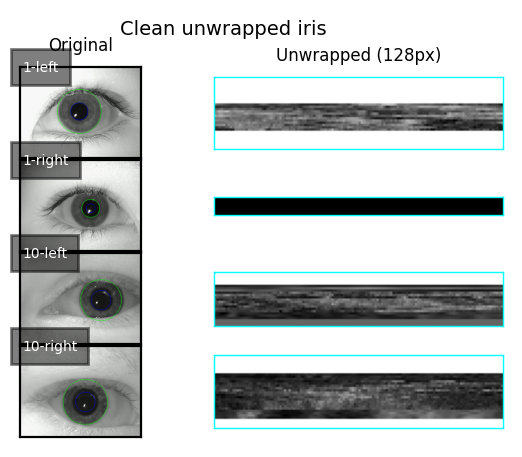

In [88]:
def detect_iris_boundary(gray_img, processed_img, pupil_boundary, threshold):
    if pupil_boundary is None:
        return None

    pupil_x, pupil_y, pupil_radius = pupil_boundary

    roi_radius = int(pupil_radius * 4.5)
    roi_x1 = max(0, pupil_x - roi_radius)
    roi_y1 = max(0, pupil_y - roi_radius)
    roi_x2 = min(gray_img.shape[1], pupil_x + roi_radius)
    roi_y2 = min(gray_img.shape[0], pupil_y + roi_radius)

    pupil_roi_x = pupil_x - roi_x1
    pupil_roi_y = pupil_y - roi_y1

    roi_gray = processed_img[roi_y1:roi_y2, roi_x1:roi_x2].copy()

    gx = cv2.Sobel(roi_gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(roi_gray, cv2.CV_32F, 0, 1, ksize=3)
    edge_map = cv2.magnitude(gx, gy)
    edge_map = cv2.GaussianBlur(edge_map, (3, 3), 0)
    edge_map = cv2.normalize(edge_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    mask = np.zeros_like(roi_gray)
    cv2.circle(mask, (pupil_roi_x, pupil_roi_y), int(pupil_radius * 4), 255, -1)
    cv2.circle(mask, (pupil_roi_x, pupil_roi_y), int(pupil_radius * 1.2), 0, -1)
    edge_map = cv2.bitwise_and(edge_map, edge_map, mask=mask)

    angles = np.arange(0, 360, 5)
    radii = []
    min_r = int(pupil_radius * 1.5)
    max_r = int(pupil_radius * 4.0)

    for angle in angles:
        angle_rad = np.deg2rad(angle)
        cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
        radial_profile = []

        for r in range(min_r, max_r):
            x = int(pupil_roi_x + r * cos_a)
            y = int(pupil_roi_y + r * sin_a)

            if 0 <= x < edge_map.shape[1] and 0 <= y < edge_map.shape[0]:
                radial_profile.append((r, edge_map[y, x]))

        if radial_profile:
            best_r, _ = max(radial_profile, key=lambda p: p[1])
            radii.append(best_r)

    if radii:
        radii = np.array(radii)
        median_r = np.median(radii)
        mad = np.median(np.abs(radii - median_r))

        good_radii = radii[np.abs(radii - median_r) < 2.0 * mad]

        if len(good_radii) > 0:
            iris_radius = int(np.median(good_radii))
        else:
            iris_radius = int(median_r)
    else:
        h_proj = np.sum(edge_map, axis=0)
        v_proj = np.sum(edge_map, axis=1)

        h_indices = np.arange(len(h_proj))
        h_center = np.sum(h_indices * h_proj) / (np.sum(h_proj) + 1e-6)
        h_width = np.sqrt(np.sum((h_indices - h_center) ** 2 * h_proj) / (np.sum(h_proj) + 1e-6))

        v_indices = np.arange(len(v_proj))
        v_center = np.sum(v_indices * v_proj) / (np.sum(v_proj) + 1e-6)
        v_width = np.sqrt(np.sum((v_indices - v_center) ** 2 * v_proj) / (np.sum(v_proj) + 1e-6))

        iris_radius = int((h_width + v_width) / 2)

    iris_radius = max(int(pupil_radius * 2.0), min(iris_radius, int(pupil_radius * 4.0)))
    return (pupil_x, pupil_y, iris_radius)

def unwrap_iris_daugman(gray_img, pupil_boundary, iris_boundary):
    if pupil_boundary is None or iris_boundary is None:
        z = np.zeros((100, 360), np.uint8)
        return z, z

    cx, cy, _ = pupil_boundary
    _, _, pr = pupil_boundary
    _, _, ir = iris_boundary

    H = ir - pr
    if H <= 0:
        z = np.zeros((100, 360), np.uint8)
        return z, z

    W = 360
    ring_w = max(1, math.ceil(H / 8))
    img_h, img_w = gray_img.shape

    ang = [
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 225)],
        [(0, 225)],
        [(0, 60), (300, 359)],
        [(60, 149), (320, 359)],
    ]

    unwrapped = np.zeros((H, W), np.uint8)
    mask = np.zeros_like(unwrapped)

    cos_tbl = np.cos(np.deg2rad(np.arange(W)))
    sin_tbl = np.sin(np.deg2rad(np.arange(W)))

    for deg in range(W):
        for r in range(H):
            ring = min(7, r // ring_w)
            if not any(lo <= deg <= hi for lo, hi in ang[ring]):
                continue

            rr = pr + r
            x = int(cx + rr * cos_tbl[deg])
            y = int(cy + rr * sin_tbl[deg])
            if 0 <= x < img_w and 0 <= y < img_h:
                unwrapped[r, deg] = gray_img[y, x]
                mask[r, deg] = 255

    lashes = np.zeros_like(mask)
    for deg in range(W):
        col = unwrapped[:, deg][mask[:, deg] > 0]
        if col.size == 0:
            continue
        thr = np.percentile(col, 20)
        dark = unwrapped[:, deg] < thr
        lashes[:, deg][dark] = 255

    valid_pix = unwrapped[mask > 0]
    if valid_pix.size:
        mu, sigma = valid_pix.mean(), valid_pix.std()
        glare = (unwrapped > mu + 2.5 * sigma) & (mask > 0)
        lashes[glare] = 255

    h_k = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 3))
    lashes = cv2.morphologyEx(lashes, cv2.MORPH_DILATE, h_k, iterations=2)
    lashes = cv2.morphologyEx(lashes, cv2.MORPH_CLOSE, h_k, iterations=1)

    mask[lashes > 0] = 0

    return unwrapped, mask

def create_clean_unwrapped_iris(daugman_unwrapped, daugman_mask, output_width=128):
    if daugman_unwrapped is None or daugman_mask is None:
        return np.zeros((100, output_width), dtype=np.uint8)

    H, W = daugman_unwrapped.shape
    ring_h = max(1, H // 8)

    ang = [
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 225)],
        [(0, 225)],
        [(0, 60), (300, 359)],
        [(60, 149), (320, 359)],
    ]

    output_height = 8 * ring_h
    clean_unwrapped = np.zeros((output_height, output_width), dtype=np.uint8)

    for ring_idx in range(8):
        ring_start = ring_idx * ring_h
        ring_end = min(H, (ring_idx + 1) * ring_h)
        output_ring_start = ring_idx * ring_h
        output_ring_end = (ring_idx + 1) * ring_h

        if ring_end <= ring_start:
            continue

        ring_data = daugman_unwrapped[ring_start:ring_end, :]
        ring_mask = daugman_mask[ring_start:ring_end, :]
        valid_pixels = []

        for lo, hi in ang[ring_idx]:
            segment = ring_data[:, lo:hi + 1]
            segment_mask = ring_mask[:, lo:hi + 1]
            valid_segment = segment[segment_mask > 0]

            if len(valid_segment) > 0:
                valid_pixels.append(valid_segment)

        if valid_pixels and len(valid_pixels) > 0:
            all_valid_pixels = np.concatenate(valid_pixels)

            if len(all_valid_pixels) > 0:
                avg_value = np.mean(all_valid_pixels).astype(np.uint8)
                valid_height = ring_end - ring_start
                valid_width = len(all_valid_pixels) // valid_height

                if valid_width > 0:
                    num_pixels = valid_height * valid_width
                    if num_pixels <= len(all_valid_pixels):
                        valid_data = all_valid_pixels[:num_pixels].reshape(valid_height, valid_width)
                        ring_resized = cv2.resize(
                            valid_data,
                            (output_width, valid_height),
                            interpolation=cv2.INTER_LANCZOS4
                        )
                        clean_unwrapped[output_ring_start:output_ring_end, :] = ring_resized
                    else:
                        clean_unwrapped[output_ring_start:output_ring_end, :] = avg_value
                else:
                    clean_unwrapped[output_ring_start:output_ring_end, :] = avg_value
            else:
                clean_unwrapped[output_ring_start:output_ring_end, :] = 128
        else:
            clean_unwrapped[output_ring_start:output_ring_end, :] = 128

    return clean_unwrapped

def visualize_clean_unwrapped_iris(base_path="data/MMU-Iris-Database", num_samples=4, output_file="clean_unwrapped_iris.png"):
    samples = []

    for subject in sorted(os.listdir(base_path)):
        subject_path = os.path.join(base_path, subject)
        if not os.path.isdir(subject_path):
            continue

        for eye in ['left', 'right']:
            eye_path = os.path.join(subject_path, eye)
            if not os.path.isdir(eye_path):
                continue

            for img_file in sorted(os.listdir(eye_path)):
                if img_file.endswith('.bmp'):
                    img_path = os.path.join(eye_path, img_file)
                    samples.append((subject, eye, img_path))
                    break

            if len(samples) >= num_samples:
                break

        if len(samples) >= num_samples:
            break

    if len(samples) == 0:
        print("No images found")
        return

    fig, axes = plt.subplots(
        nrows=len(samples),
        ncols=2,
        figsize=(3.5, 0.6*len(samples)),
        dpi=200,
        gridspec_kw={'hspace': 0.02, 'wspace': 0.05, 'width_ratios': [1, 1.2]}
    )

    fig.patch.set_facecolor('white')

    for i, (subject, eye, img_path) in enumerate(samples):
        img = cv2.imread(img_path)
        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        processed = preprocess(gray)

        global_mean = np.mean(gray)
        pupil_threshold = global_mean / 3.5
        iris_threshold = global_mean / 1.8

        pupil_boundary, _ = detect_pupil_boundary(gray, processed, pupil_threshold)

        if pupil_boundary is not None:
            iris_boundary = detect_iris_boundary(gray, processed, pupil_boundary, iris_threshold)
        else:
            iris_boundary = None

        result_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()

        if pupil_boundary and iris_boundary:
            px, py, pr = pupil_boundary
            ix, iy, ir = iris_boundary

            cv2.circle(result_img, (px, py), pr, (0, 0, 255), 1)
            cv2.circle(result_img, (ix, iy), ir, (0, 255, 0), 1)

        axes[i, 0].imshow(result_img)
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        axes[i, 0].text(5, 10, f"{subject}-{eye}", fontsize=5,
                      color='white', bbox=dict(facecolor='black', alpha=0.5))

        if pupil_boundary and iris_boundary:
            daugman_unwrapped, daugman_mask = unwrap_iris_daugman(gray, pupil_boundary, iris_boundary)
            clean_unwrapped = create_clean_unwrapped_iris(daugman_unwrapped, daugman_mask, output_width=128)
            axes[i, 1].imshow(clean_unwrapped, cmap='gray')

            axes[i, 1].spines['top'].set_color('cyan')
            axes[i, 1].spines['bottom'].set_color('cyan')
            axes[i, 1].spines['left'].set_color('cyan')
            axes[i, 1].spines['right'].set_color('cyan')
            axes[i, 1].spines['top'].set_linewidth(0.5)
            axes[i, 1].spines['bottom'].set_linewidth(0.5)
            axes[i, 1].spines['left'].set_linewidth(0.5)
            axes[i, 1].spines['right'].set_linewidth(0.5)
        else:
            axes[i, 1].text(0.5, 0.5, "Failed", ha='center', va='center', fontsize=5)
            axes[i, 1].imshow(np.zeros((10, 10)), cmap='gray')

        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])

    if len(samples) > 0:
        axes[0, 0].set_title('Original', fontsize=6)
        axes[0, 1].set_title('Unwrapped (128px)', fontsize=6)

    plt.suptitle("Clean unwrapped iris", fontsize=7, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0.02, facecolor='white')
    plt.show()

visualize_clean_unwrapped_iris()

C:\Users\igorr\AppData\Local\Temp\ipykernel_101872\1828162648.py:286: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


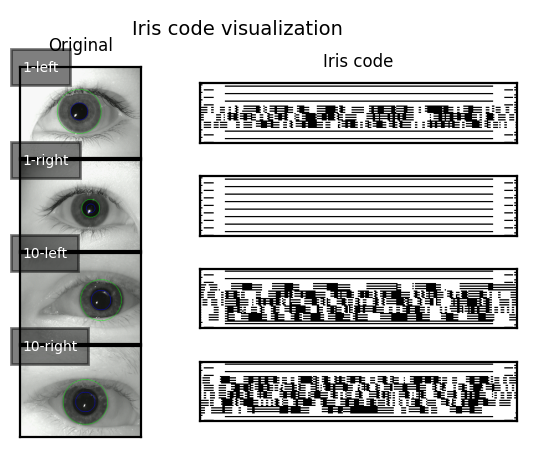

In [90]:
def unwrap_iris_daugman(gray_img, pupil_boundary, iris_boundary):
    if pupil_boundary is None or iris_boundary is None:
        z = np.zeros((100, 360), np.uint8)
        return z, z

    cx, cy, _ = pupil_boundary
    _, _, pr = pupil_boundary
    _, _, ir = iris_boundary

    H = ir - pr
    if H <= 0:
        z = np.zeros((100, 360), np.uint8)
        return z, z

    W = 360
    ring_w = max(1, math.ceil(H / 8))
    img_h, img_w = gray_img.shape

    ang = [
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 225)],
        [(0, 225)],
        [(0, 60), (300, 359)],
        [(60, 149), (320, 359)],
    ]

    unwrapped = np.zeros((H, W), np.uint8)
    mask = np.zeros_like(unwrapped)

    cos_tbl = np.cos(np.deg2rad(np.arange(W)))
    sin_tbl = np.sin(np.deg2rad(np.arange(W)))

    for deg in range(W):
        for r in range(H):
            ring = min(7, r // ring_w)
            if not any(lo <= deg <= hi for lo, hi in ang[ring]):
                continue

            rr = pr + r
            x = int(cx + rr * cos_tbl[deg])
            y = int(cy + rr * sin_tbl[deg])
            if 0 <= x < img_w and 0 <= y < img_h:
                unwrapped[r, deg] = gray_img[y, x]
                mask[r, deg] = 255

    lashes = np.zeros_like(mask)
    for deg in range(W):
        col = unwrapped[:, deg][mask[:, deg] > 0]
        if col.size == 0:
            continue
        thr = np.percentile(col, 20)
        dark = unwrapped[:, deg] < thr
        lashes[:, deg][dark] = 255

    valid_pix = unwrapped[mask > 0]
    if valid_pix.size:
        mu, sigma = valid_pix.mean(), valid_pix.std()
        glare = (unwrapped > mu + 2.5 * sigma) & (mask > 0)
        lashes[glare] = 255

    h_k = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 3))
    lashes = cv2.morphologyEx(lashes, cv2.MORPH_DILATE, h_k, iterations=2)
    lashes = cv2.morphologyEx(lashes, cv2.MORPH_CLOSE, h_k, iterations=1)

    mask[lashes > 0] = 0

    return unwrapped, mask

def create_clean_unwrapped_iris(daugman_unwrapped, daugman_mask, output_width=128):
    if daugman_unwrapped is None or daugman_mask is None:
        return np.zeros((100, output_width), dtype=np.uint8)

    H, W = daugman_unwrapped.shape
    ring_h = max(1, H // 8)

    ang = [
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 254), (286, 359)],
        [(0, 225)],
        [(0, 225)],
        [(0, 60), (300, 359)],
        [(60, 149), (320, 359)],
    ]

    output_height = 8 * ring_h
    clean_unwrapped = np.zeros((output_height, output_width), dtype=np.uint8)

    for ring_idx in range(8):
        ring_start = ring_idx * ring_h
        ring_end = min(H, (ring_idx + 1) * ring_h)
        output_ring_start = ring_idx * ring_h
        output_ring_end = (ring_idx + 1) * ring_h

        if ring_end <= ring_start:
            continue

        ring_data = daugman_unwrapped[ring_start:ring_end, :]
        ring_mask = daugman_mask[ring_start:ring_end, :]
        valid_pixels = []

        for lo, hi in ang[ring_idx]:
            segment = ring_data[:, lo:hi + 1]
            segment_mask = ring_mask[:, lo:hi + 1]
            valid_segment = segment[segment_mask > 0]

            if len(valid_segment) > 0:
                valid_pixels.append(valid_segment)

        if valid_pixels and len(valid_pixels) > 0:
            all_valid_pixels = np.concatenate(valid_pixels)

            if len(all_valid_pixels) > 0:
                avg_value = np.mean(all_valid_pixels).astype(np.uint8)
                valid_height = ring_end - ring_start
                valid_width = len(all_valid_pixels) // valid_height

                if valid_width > 0:
                    num_pixels = valid_height * valid_width
                    if num_pixels <= len(all_valid_pixels):
                        valid_data = all_valid_pixels[:num_pixels].reshape(valid_height, valid_width)
                        ring_resized = cv2.resize(
                            valid_data,
                            (output_width, valid_height),
                            interpolation=cv2.INTER_LANCZOS4
                        )
                        clean_unwrapped[output_ring_start:output_ring_end, :] = ring_resized
                    else:
                        clean_unwrapped[output_ring_start:output_ring_end, :] = avg_value
                else:
                    clean_unwrapped[output_ring_start:output_ring_end, :] = avg_value
            else:
                clean_unwrapped[output_ring_start:output_ring_end, :] = 128
        else:
            clean_unwrapped[output_ring_start:output_ring_end, :] = 128

    return clean_unwrapped

def extract_ring_signals(clean_img, n_pts=256):
    H, W = clean_img.shape
    ring_h = H // 8
    g = cv2.getGaussianKernel(ksize=ring_h * 2 + 1, sigma=ring_h / 3).flatten()[:ring_h]

    signals = np.zeros((8, n_pts), dtype=np.float32)
    for idx in range(8):
        band = clean_img[idx * ring_h:(idx + 1) * ring_h, :]
        weighted = (band * g[:, None]).sum(axis=0) / g.sum()
        signals[idx] = cv2.resize(weighted[np.newaxis, :],
                                 (n_pts, 1),
                                 interpolation=cv2.INTER_LINEAR)[0]
    return signals

def gabor_kernel_1d(f, ksize=41):
    sigma = 0.5 * math.pi * f
    half = ksize // 2
    x = np.arange(-half, half + 1, dtype=np.float32)
    gauss = np.exp(-(x ** 2) / (2 * sigma ** 2))
    carrier = np.exp(1j * 2 * math.pi * f * x)
    kernel = gauss * carrier
    kernel -= kernel.mean()
    return kernel

def compute_iris_code(signals, f_base=0.25):
    frequencies = [f_base*0.7, f_base, f_base*1.3]
    n_rings, n_pts = signals.shape
    code = np.zeros((n_rings, n_pts, len(frequencies)*2), dtype=np.uint8)

    for i, f in enumerate(frequencies):
        k = gabor_kernel_1d(f)
        k_r, k_i = k.real.astype(np.float32), k.imag.astype(np.float32)

        for r in range(n_rings):
            s = signals[r]
            resp_r = np.convolve(s, k_r, mode='same')
            resp_i = np.convolve(s, k_i, mode='same')
            code[r, :, i*2] = (resp_r >= 0).astype(np.uint8)
            code[r, :, i*2+1] = (resp_i >= 0).astype(np.uint8)

    img = np.zeros((2 * n_rings * len(frequencies), n_pts), dtype=np.uint8)
    for r in range(n_rings):
        for i in range(len(frequencies)):
            img[2*(r*len(frequencies)+i)] = code[r, :, i*2] * 255
            img[2*(r*len(frequencies)+i)+1] = code[r, :, i*2+1] * 255
    return code, img

def visualize_iris_code(base_path="data/MMU-Iris-Database", num_samples=4, output_file="iris_code.png"):
    samples = []

    for subject in sorted(os.listdir(base_path)):
        subject_path = os.path.join(base_path, subject)
        if not os.path.isdir(subject_path):
            continue

        for eye in ['left', 'right']:
            eye_path = os.path.join(subject_path, eye)
            if not os.path.isdir(eye_path):
                continue

            for img_file in sorted(os.listdir(eye_path)):
                if img_file.endswith('.bmp'):
                    img_path = os.path.join(eye_path, img_file)
                    samples.append((subject, eye, img_path))
                    break

            if len(samples) >= num_samples:
                break

        if len(samples) >= num_samples:
            break

    if len(samples) == 0:
        print("No images found")
        return

    fig, axes = plt.subplots(
        nrows=len(samples),
        ncols=2,
        figsize=(3.5, 0.6*len(samples)),
        dpi=200,
        gridspec_kw={'hspace': 0.02, 'wspace': 0.05, 'width_ratios': [1, 1.5]}
    )

    fig.patch.set_facecolor('white')

    for i, (subject, eye, img_path) in enumerate(samples):
        img = cv2.imread(img_path)
        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        processed = preprocess(gray)

        global_mean = np.mean(gray)
        pupil_threshold = global_mean / 3.5
        iris_threshold = global_mean / 1.8

        pupil_boundary, _ = detect_pupil_boundary(gray, processed, pupil_threshold)

        if pupil_boundary is not None:
            iris_boundary = detect_iris_boundary(gray, processed, pupil_boundary, iris_threshold)
        else:
            iris_boundary = None

        result_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()

        if pupil_boundary and iris_boundary:
            px, py, pr = pupil_boundary
            ix, iy, ir = iris_boundary

            cv2.circle(result_img, (px, py), pr, (0, 0, 255), 1)
            cv2.circle(result_img, (ix, iy), ir, (0, 255, 0), 1)

        axes[i, 0].imshow(result_img)
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        axes[i, 0].text(5, 10, f"{subject}-{eye}", fontsize=5,
                      color='white', bbox=dict(facecolor='black', alpha=0.5))

        if pupil_boundary and iris_boundary:
            daugman_unwrapped, daugman_mask = unwrap_iris_daugman(gray, pupil_boundary, iris_boundary)
            clean_unwrapped = create_clean_unwrapped_iris(daugman_unwrapped, daugman_mask, output_width=128)

            if clean_unwrapped is not None:
                ring_signals = extract_ring_signals(clean_unwrapped)
                _, iris_code_img = compute_iris_code(ring_signals)
                axes[i, 1].imshow(iris_code_img, cmap='gray')
            else:
                axes[i, 1].text(0.5, 0.5, "Failed", ha='center', va='center', fontsize=5)
                axes[i, 1].imshow(np.zeros((10, 10)), cmap='gray')
        else:
            axes[i, 1].text(0.5, 0.5, "Failed", ha='center', va='center', fontsize=5)
            axes[i, 1].imshow(np.zeros((10, 10)), cmap='gray')

        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])

    if len(samples) > 0:
        axes[0, 0].set_title('Original', fontsize=6)
        axes[0, 1].set_title('Iris code', fontsize=6)

    plt.suptitle("Iris code visualization", fontsize=7, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0.02, facecolor='white')
    plt.show()

visualize_iris_code()